In [1]:
import pickle
import matplotlib.pyplot as plt
import adaptive_latents as al
import glob
import subprocess
import numpy as np
import time

In [2]:
switch_iteration = 350
subprocess.call(["python", "run_partial_start.py", "gpu", str(switch_iteration)])
subprocess.call(["python", "run_partial_start.py", "cpu", str(switch_iteration)])

# these are to compare e.g. "cpu" vs "cpu cpu"
subprocess.call(["python", "run_partial_start.py", "gpu", "None"])
subprocess.call(["python", "run_partial_start.py", "cpu", "None"])

subprocess.call(["python", "run_partial_finish.py", "gpu", "2"])
subprocess.call(["python", "run_partial_finish.py", "cpu", "4"])

/home/jgould/Documents/AdaptiveLatents/scripts/debug jax/run_partial_start.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/home/jgould/Documents/AdaptiveLatents/scripts/debug jax/run_partial_start.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/home/jgould/Documents/AdaptiveLatents/scripts/debug jax/run_partial_start.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/home/jgould/Documents/AdaptiveLatents/scripts/debug jax/run_partial_start.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/home/jgould/Documents/AdaptiveLatents/scripts/debug jax/run_partial_finish.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/home/jgo

0

In [3]:
files = sorted(glob.glob(f"{al.CONFIG["output_path"]/"bubblewrap_runs"}/*.pickle"))
brs = []
for file in files[-6:]:
    with open(file, 'br') as fhan:
        brs.append(pickle.load(fhan))
brs = np.array(brs)
brs = brs.reshape(-1,2)

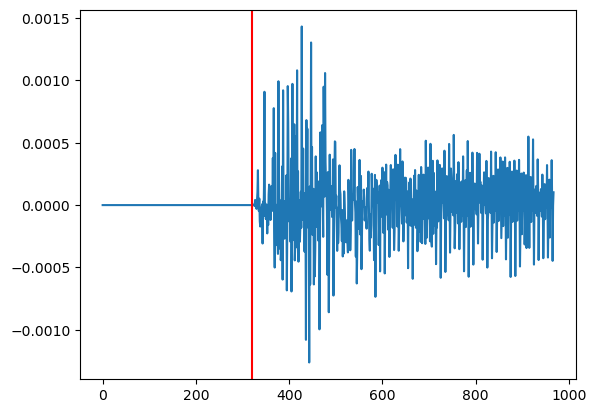

In [4]:
%matplotlib inline
plt.plot(brs[0,1].h.entropy[1] - brs[-1,1].h.entropy[1])
plt.axvline(switch_iteration-brs[0,0].bw.M, color='red');
# assert abs((switch_iteration - brs[0,0].bw.M) - (np.nonzero(brs[0,1].h.entropy[1] - brs[-1,1].h.entropy[1] > 0)[0][0])) < 5

/home/jgould/Documents/AdaptiveLatents/adaptive_latents/plotting_functions.py:480: UserWarning: check these timepoints actually line up, I'm just clipping here
  warnings.warn("check these timepoints actually line up, I'm just clipping here")


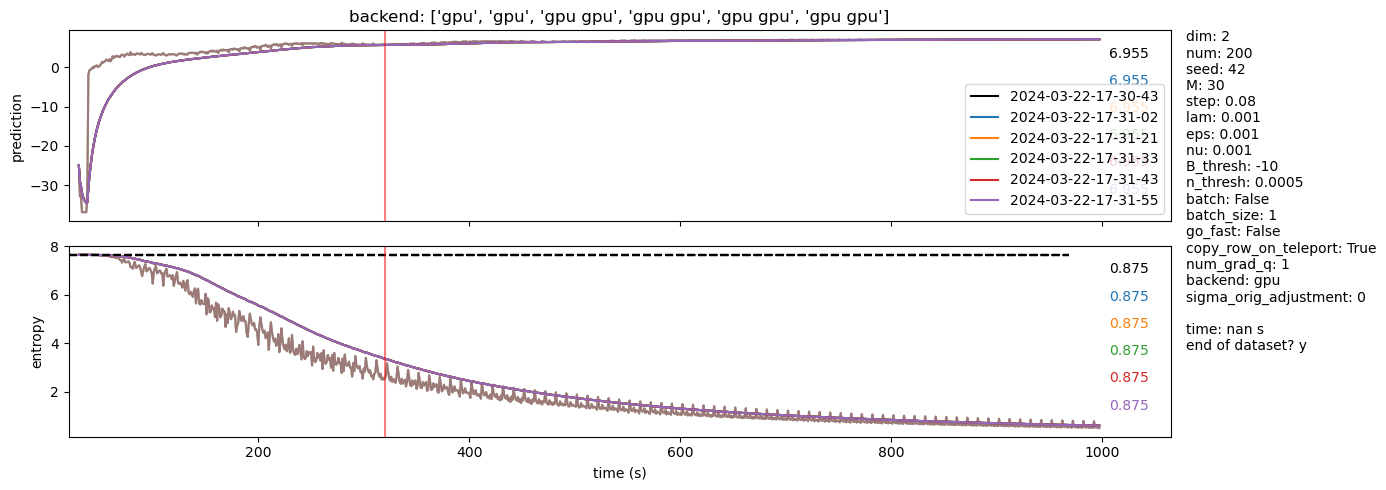

In [5]:
%matplotlib inline
# red_lines=[brs[0,0].obs_ds.t[switch_iteration]]
al.plotting_functions.compare_metrics(brs.flatten(), 1, red_lines=[brs[0,0].input_ds.t[switch_iteration-brs[0,0].bw.M]])

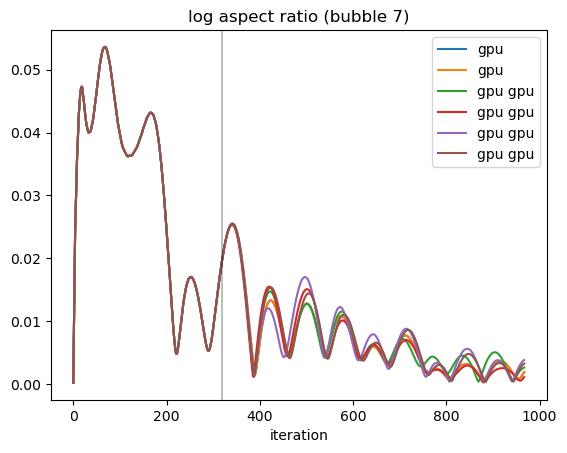

In [6]:
def show_aspect_ratio_divergence(brs, bubble=5, switch=250):
    fig,ax = plt.subplots()
    
    m = bubble
    for k in range(len(brs)):
        ratios = []
        for i in range(brs[k].h.L.shape[0]):
            L = brs[k].h.L[i,m,...]
            _, s, _= np.linalg.svd(np.linalg.pinv(L.T@L))
            ratios.append(s.max() / s.min())
        ratios = np.log(ratios)
        ax.plot(ratios, label=brs[k].bw.backend_note)
    
    ax.set_title(f"log aspect ratio (bubble {m})");
    ax.legend();
    ax.axvline(switch-brs[0].bw.M, color='k', alpha=.25);
    ax.set_xlabel("iteration");
show_aspect_ratio_divergence(brs.flatten(), bubble=7, switch=switch_iteration)

## Inspect a single switch

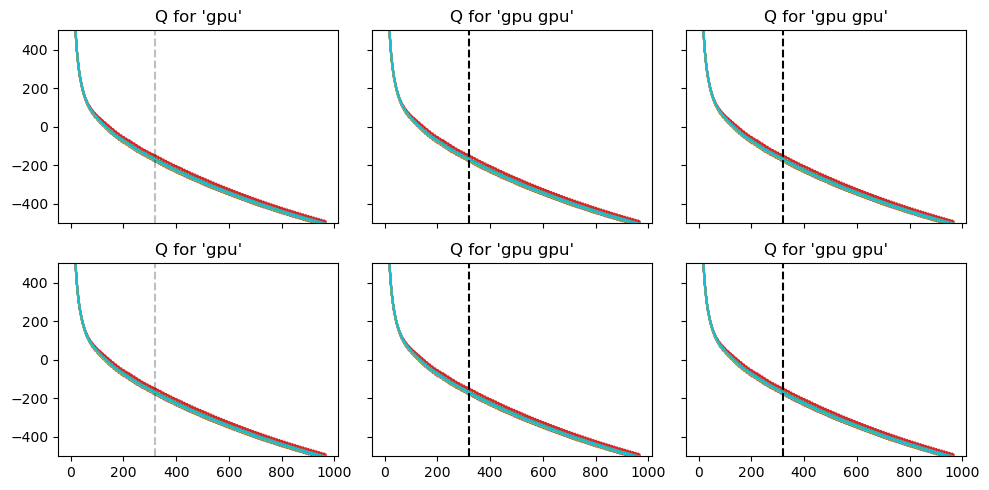

In [7]:
%matplotlib inline

fig, axs = plt.subplots(nrows=2, ncols=brs.shape[0], figsize=(10,5), layout='tight', sharey=True, sharex=True);
for i in range(brs.shape[0]):
    for j in range(brs.shape[1]):
        br = brs[i][j]
        Q = br.h.Q;

        alive_at_end = br.h.n_obs[-1] > 5;
        Q = Q[:, alive_at_end]
        log_Q = np.log(np.abs(Q));
        axs[j,i].plot(Q);

        axs[j,i].axvline(switch_iteration - brs[0,0].bw.M, color='k', linestyle='--', alpha=.25 if i==0 else 1)
        axs[j,i].set_title(f"Q for '{br.bw.backend_note}'");
        axs[j,i].set_ylim([-500,500]);

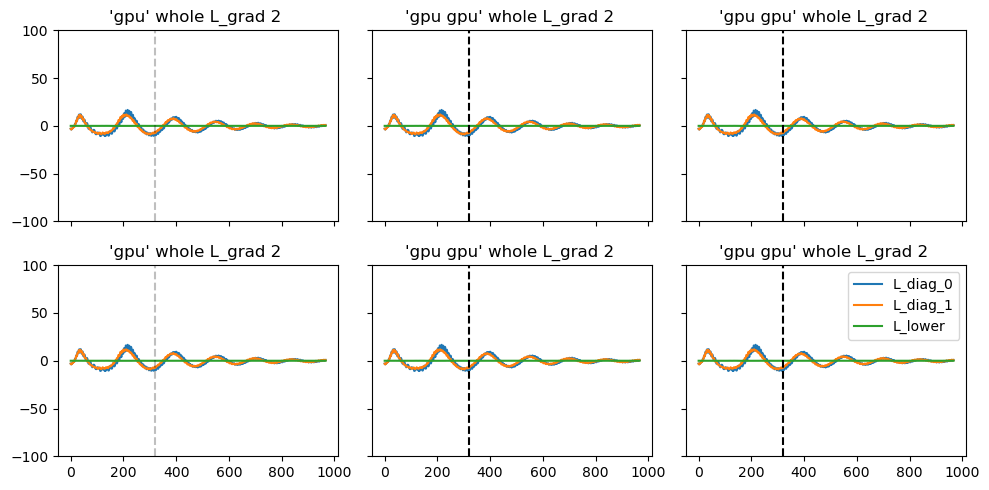

In [8]:
%matplotlib inline

bubble = 2
fig, axs = plt.subplots(nrows=2, ncols=brs.shape[0], figsize=(10,5), layout='tight', sharey=True, sharex=True);
for i in range(brs.shape[0]):
    for j in range(brs.shape[1]):
        br = brs[i][j]
        
        axs[j,i].plot(br.h.L_diag_grad[:, bubble, :]);
        axs[j,i].plot(br.h.L_lower_grad[:, bubble, *np.tril_indices(2, k=-1)]);


        axs[j,i].axvline(switch_iteration - brs[0,0].bw.M, color='k', linestyle='--', alpha=.25 if i==0 else 1)
        axs[j,i].set_title(f"'{br.bw.backend_note}' whole L_grad {bubble} ");
        # axs[j,i].set_ylim([-.1,3])
        axs[j,i].set_ylim([-100,100])
    axs[1,2].legend(['L_diag_0', 'L_diag_1', 'L_lower'])

### Later inspection

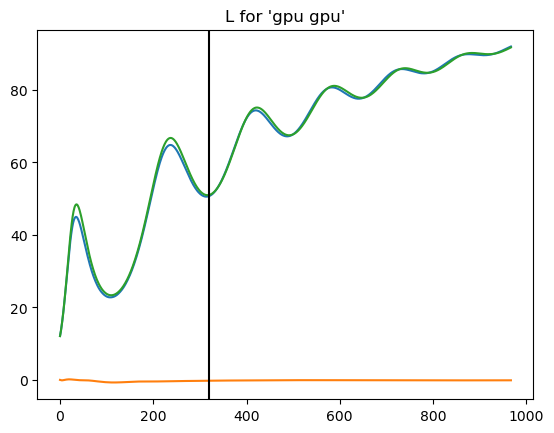

In [10]:
%matplotlib inline
br = brs[1][1]
dim = br.bw.mu.shape[1]

plt.plot((br.h.L[:,3,*np.tril_indices(dim, k=0)]))
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
# plt.ylim([0,900])
plt.title(f"L for '{br.bw.backend_note}'");

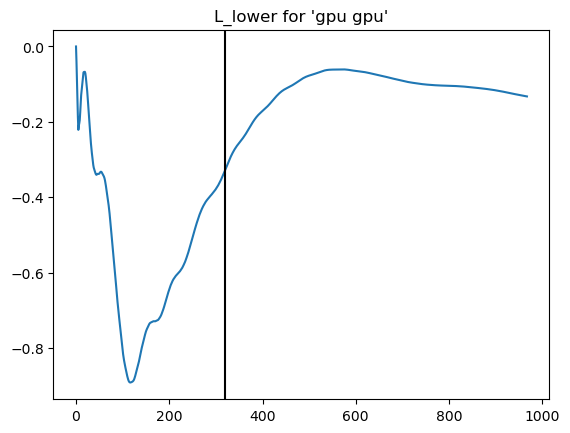

In [12]:
%matplotlib inline


plt.plot((br.h.L_lower[:,5,*np.tril_indices(dim, k=-1)]))
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
plt.title(f"L_lower for '{br.bw.backend_note}'");

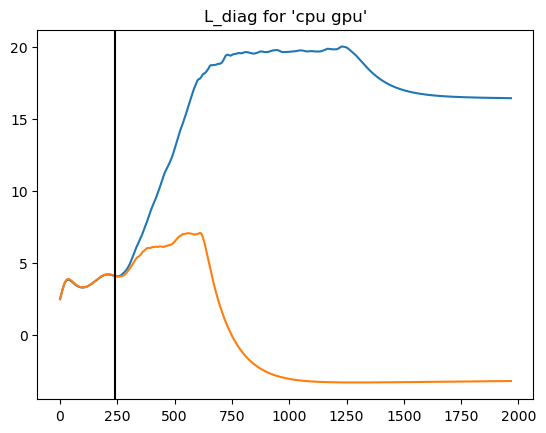

In [11]:
%matplotlib inline
dim = br.bw.mu.shape[1]

bubble=4
plt.plot((br.L_diag_history[:,bubble,...]))
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
plt.title(f"L_diag for '{br.bw.backend_note}'");

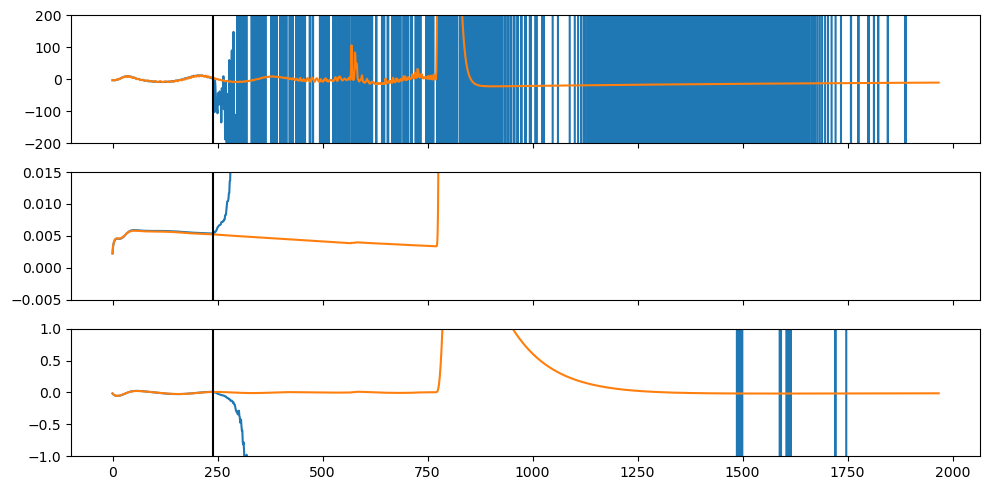

In [12]:
%matplotlib inline
fig, axs = plt.subplots(nrows=3, layout="tight", figsize=(10,5), sharex=True)

bubble = 5
axs[0].plot(br.L_diag_grad_history[:, bubble, :])
axs[0].set_ylim(np.array([-1,1])*200)

axs[1].plot(br.L_diag_v_history[:, bubble, :])
axs[1].set_ylim(np.array([-1,1])*.01 + 0.005)


axs[2].plot(br.L_diag_m_history[:, bubble, :])
axs[2].set_ylim(np.array([-1,1])*1)


for i in range(3):
    axs[i].axvline(switch_iteration - brs[0,0].bw.M, color='k')


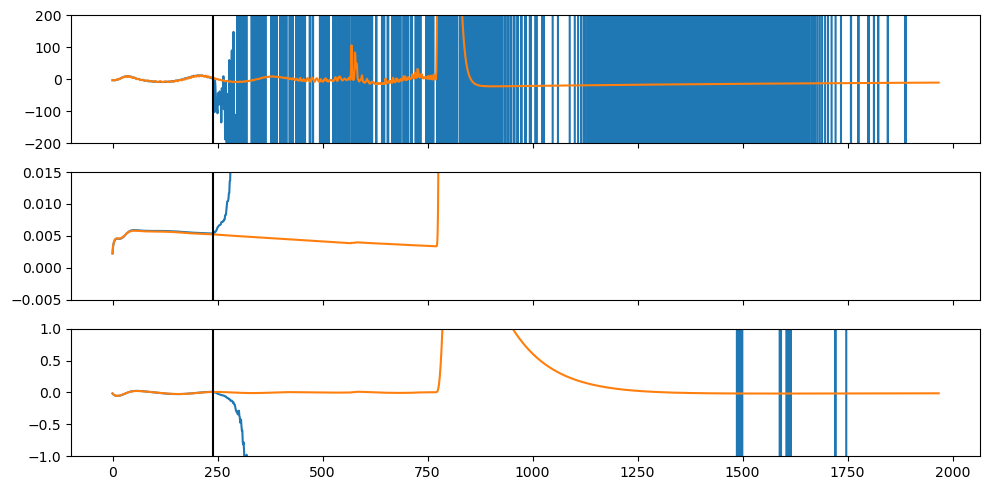

In [14]:
%matplotlib inline
fig, axs = plt.subplots(nrows=3, layout="tight", figsize=(10,5), sharex=True)

bubble = 5
axs[0].plot(br.L_diag_grad_history[:, bubble, :])
axs[0].set_ylim(np.array([-1,1])*200)

axs[1].plot(br.L_diag_v_history[:, bubble, :])
axs[1].set_ylim(np.array([-1,1])*.01 + 0.005)


axs[2].plot(br.L_diag_m_history[:, bubble, :])
axs[2].set_ylim(np.array([-1,1])*1)


for i in range(3):
    axs[i].axvline(switch_iteration - brs[0,0].bw.M, color='k')


In [15]:
br.L_diag_grad_history[switch_iteration - brs[0,0].bw.M -10, bubble, :]

array([6.7189255, 7.420312 ], dtype=float32)

In [16]:
L = br.L_history[-1][0]
L = np.linalg.inv(L)
L @ L.T

array([[ 1.2606693e-24, -1.9809505e-20],
       [-1.9809505e-20,  1.1809174e+04]], dtype=float32)

In [17]:
np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))

/tmp/ipykernel_25755/2102186140.py:1: RuntimeWarning: overflow encountered in exp
  np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))


array([[ 1.    ,  0.    ],
       [28.5152,  1.    ]], dtype=float32)

In [18]:
# 
L = np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))
el = np.linalg.inv(L)
el.T @ el

/tmp/ipykernel_25755/2669974581.py:2: RuntimeWarning: overflow encountered in exp
  L = np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))


array([[814.11664, -28.5152 ],
       [-28.5152 ,   1.     ]], dtype=float32)

In [19]:
br.L_history[-1,5,...]

array([[8.1302559e+11, 0.0000000e+00],
       [1.4317201e+02, 2.4181909e-04]], dtype=float32)

In [23]:
br.model_step_variable_history['Q']

array([[ 5.2801440e+03,  5.2797432e+03,  5.2797432e+03, ...,
         5.2797432e+03,  5.2797432e+03,  5.2797432e+03],
       [ 3.5165540e+03,  3.5110261e+03,  3.5133621e+03, ...,
         3.5133621e+03,  3.5133621e+03,  3.5133621e+03],
       [ 2.6326553e+03,  2.6304197e+03,  2.6275383e+03, ...,
         2.6299861e+03,  2.6299861e+03,  2.6299861e+03],
       ...,
       [ 3.0344894e+21,  1.0452991e+09,  2.9906784e+21, ...,
        -4.1296219e+01, -2.6876144e+01, -2.3757210e+01],
       [ 3.0344894e+21,  1.0452991e+09,  2.9892372e+21, ...,
        -4.3361996e+01, -2.6873354e+01, -2.3750235e+01],
       [ 3.0330482e+21,  1.0446437e+09,  2.9898137e+21, ...,
        -4.2366707e+01, -2.6849024e+01, -2.3741199e+01]], dtype=float32)

In [20]:
%matplotlib inline
plt.plot(np.log(np.abs(br.L_grad_history[:,5,...].reshape(-1,br.bw.mu.shape[1]**2))))
# plt.ylim([-.01,.01])
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')


AttributeError: 'BWRun' object has no attribute 'L_grad_history'

In [16]:
rng = np.random.default_rng()

In [106]:
mu = 1
sigma = 3
eps = rng.normal(size=100_000_000)
Y = mu + sigma*eps


# np.exp(Y).mean(), np.exp(mu + sigma**2/2)
np.exp(mu)*np.exp(sigma*eps).mean(), np.exp(mu + sigma**2/2)
np.exp(sigma*eps).mean(), np.exp(sigma**2/2)


(88.77925779493576, 90.01713130052181)

In [109]:
(eps**6).mean()

14.984705554831354

246.10631318876332